In [281]:
from zget_data import get_responses, get_qdetails, get_questions, get_design, page_map, quest_map, attention, did_map
from scipy.stats import shapiro, yeojohnson, kruskal
import scikit_posthocs as sp
from collections import defaultdict
from selenium import webdriver
from selenium.webdriver.common.by import By
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import json
import os

In [282]:
password_response, time_response, survey_response, dids = get_responses()

Total: 163; 
Attentive: 131; Non Attentive: 32


In [283]:
password_response_df = pd.DataFrame(password_response)
passwords = password_response_df['password2'].to_list()

pass_strength = {}

pfile = "data/password/pstrength.json"
if os.path.exists(pfile):
    with open(pfile, "r") as fp:
        pass_strength.update(json.load(fp))
else:
    driver = webdriver.Chrome()
    driver.get("https://passwordmonster.com")

    for pss in passwords:
        element = driver.find_element(By.ID, 'lgd_out_pg_pass')
        element.send_keys(pss)
        element.clear()
        complexity = driver.find_element(By.ID, 'complexity-span')
        pass_strength[pss] = complexity.get_attribute("innerHTML")

    with open("password/pstrength.json", "w") as fp:
        json.dump(pass_strength, fp)

In [284]:
pass_stmap = {
    'Very Weak': -3,
    'Weak': -1.5,
    'Medium': 0,
    'Strong': 1.5,
    'Very Strong': 3,
}
password_response_df['Actual Strength'] = password_response_df['password2'].apply(lambda x: pass_stmap.get(pass_strength.get(x)))
password_response_df

,password2,password2_recall1,password2_recall2,password2_recall3,Actual Strength
0,Prolific1!,NaN,NaN,NaN,-3.0
1,pSVNLb85CUNPCwX,NaN,NaN,NaN,3.0
2,CozyBi11$,NaN,NaN,NaN,-1.5
3,PRO333TECT,NaN,NaN,NaN,3.0
4,amandanike@91s,NaN,NaN,NaN,0.0
...,...,...,...,...,...
126,m0gRBn$^$V95806MS*jl,NaN,NaN,NaN,3.0
127,Ws14827!Ld,NaN,NaN,NaN,3.0
128,DCs#Bnk7,DCsBnk7,DCs#BNk7,NaN,3.0
129,4518184@@,NaN,NaN,NaN,0.0


In [285]:
survey_response_df = pd.DataFrame(survey_response)

page_id = '3'
normqsid = ['1-1', '1-4']
fpass = pd.DataFrame(survey_response_df[page_id].to_dict()).astype(int)
normfpass = 8 - fpass.loc[normqsid]
fpass.update(normfpass)

new_index = {}
for qsid in fpass.index:
    likert_scale = 'low' if qsid in normqsid else 'high'
    new_index[qsid] = json.loads(get_qdetails(page_id, qsid).replace("'", '"').split('\n')[1]).get('title')
fpass.rename(columns=new_index, inplace=True)
fpass = fpass.rename(new_index)
password_generation = pd.DataFrame(fpass.T.mean(axis=1), columns=['Password Generation'])
pg_prenorm = password_generation.join(pd.DataFrame([get_design(str(did)) for did in dids], columns=['design']))

# normalize scale 1 to 8 to scale -3 to 3
normspassb = password_generation - 4
password_generation.update(normspassb)

/var/folders/y0/_c2r85zn1137ydw7ltj1v0pr0000gq/T/ipykernel_21687/366780574.py:7: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  fpass.update(normfpass)


In [286]:
page_id = '12'
normqsid = []
spass = pd.DataFrame(survey_response_df[page_id].to_dict()).astype(int)
spass.drop(attention.get('12'), inplace=True)
normspass = 8 - spass.loc[normqsid]
spass.update(normspass)

# normalize scale 1 to 8 to scale -3 to 3
normspass = spass - 4
spass.update(normspass)

new_index = {}
for qsid in spass.index:
    new_index[qsid] = json.loads(get_qdetails(page_id, qsid).replace("'", '"').split('\n')[1]).get('keyword')
new_index
spass = spass.rename(new_index)
spass = spass.T

In [287]:
password = spass.join(password_generation).join(password_response_df['Actual Strength']).join(pd.DataFrame([get_design(str(did)) for did in dids], columns=['design']))
password.to_csv("data/csvs/password.csv", index=False)
display(password.head())
password.mean()

,Password Strength,Motivation After Design,Hard to Remember,Guessed by Hacker,Guessed by FnF,Stronger than Usual,Password Generation,Actual Strength,design
0,2,1,-3,-2,-3,-1,-1.25,-3.0,Metaphor
1,3,-3,3,-3,-3,0,1.75,3.0,Personal
2,2,2,-2,-1,-3,2,-2.00,-1.5,Consequences
3,2,3,2,-3,-3,2,1.50,3.0,Consequences
4,3,3,2,-3,-3,3,1.75,0.0,Logos


/var/folders/y0/_c2r85zn1137ydw7ltj1v0pr0000gq/T/ipykernel_21687/2300871009.py:4: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  password.mean()


Password Strength          1.877863
Motivation After Design    1.755725
Hard to Remember           0.305344
Guessed by Hacker         -1.038168
Guessed by FnF            -1.297710
Stronger than Usual        0.763359
Password Generation        0.583969
Actual Strength           -0.137405
dtype: float64

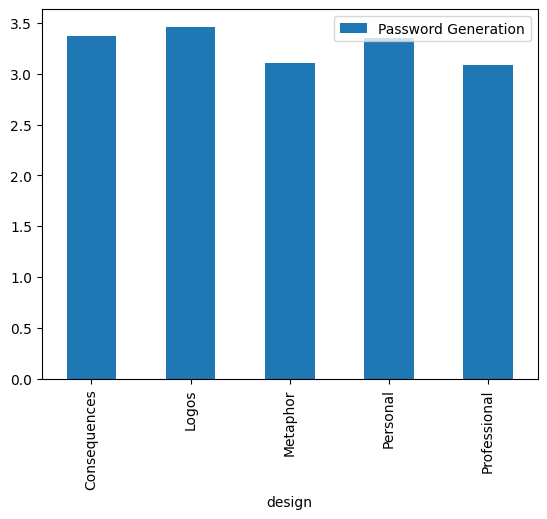

In [288]:
_ = pg_prenorm.groupby('design').mean().div(7).mul(5).plot.bar()

/var/folders/y0/_c2r85zn1137ydw7ltj1v0pr0000gq/T/ipykernel_21687/1550836245.py:1: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  pg_prenorm.mean().div(7).mul(5).plot.bar()


<AxesSubplot: >

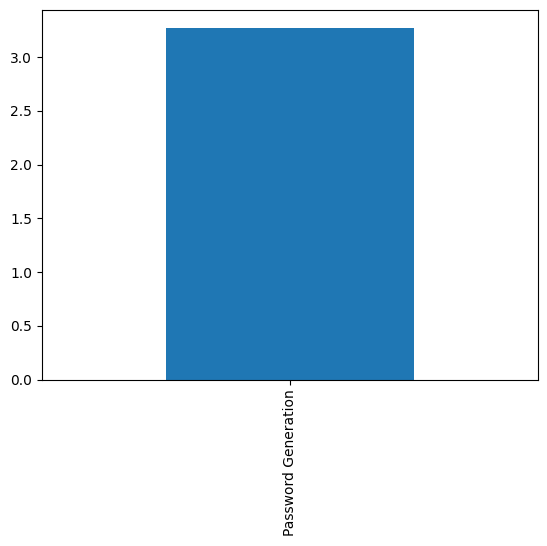

In [289]:
pg_prenorm.mean().div(7).mul(5).plot.bar()

In [290]:
password

,Password Strength,Motivation After Design,Hard to Remember,Guessed by Hacker,Guessed by FnF,Stronger than Usual,Password Generation,Actual Strength,design
0,2,1,-3,-2,-3,-1,-1.25,-3.0,Metaphor
1,3,-3,3,-3,-3,0,1.75,3.0,Personal
2,2,2,-2,-1,-3,2,-2.00,-1.5,Consequences
3,2,3,2,-3,-3,2,1.50,3.0,Consequences
4,3,3,2,-3,-3,3,1.75,0.0,Logos
...,...,...,...,...,...,...,...,...,...
126,3,0,3,-3,-3,-2,2.75,3.0,Logos
127,2,3,3,-3,-3,1,1.50,3.0,Consequences
128,2,2,1,-2,-2,-1,1.50,3.0,Professional
129,1,2,-1,-1,0,-2,0.75,0.0,Logos


In [291]:
len(password_response_df['password2_recall1'].dropna()), len(password_response_df['password2_recall2'].dropna()), len(password_response_df['password2_recall3'].dropna())

(4, 2, 1)

<AxesSubplot: xlabel='Actual Strength', ylabel='Count'>

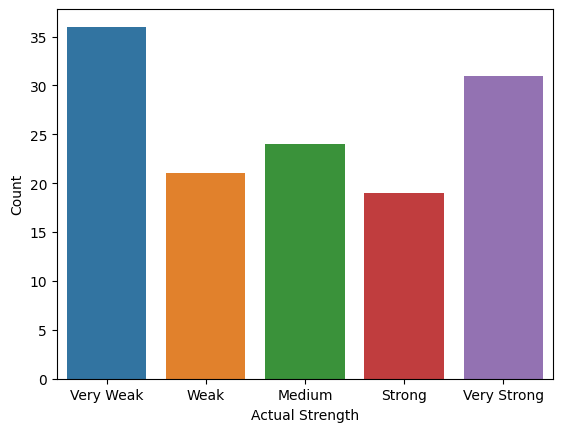

In [292]:
strength_count = password['Actual Strength'].apply(lambda x: list(pass_stmap.keys())[list(pass_stmap.values()).index(x)]).value_counts().rename_axis("Actual Strength").reset_index(name="Count")
sns.barplot(data=strength_count, x='Actual Strength', y='Count', order=['Very Weak', 'Weak', 'Medium', 'Strong', 'Very Strong'])

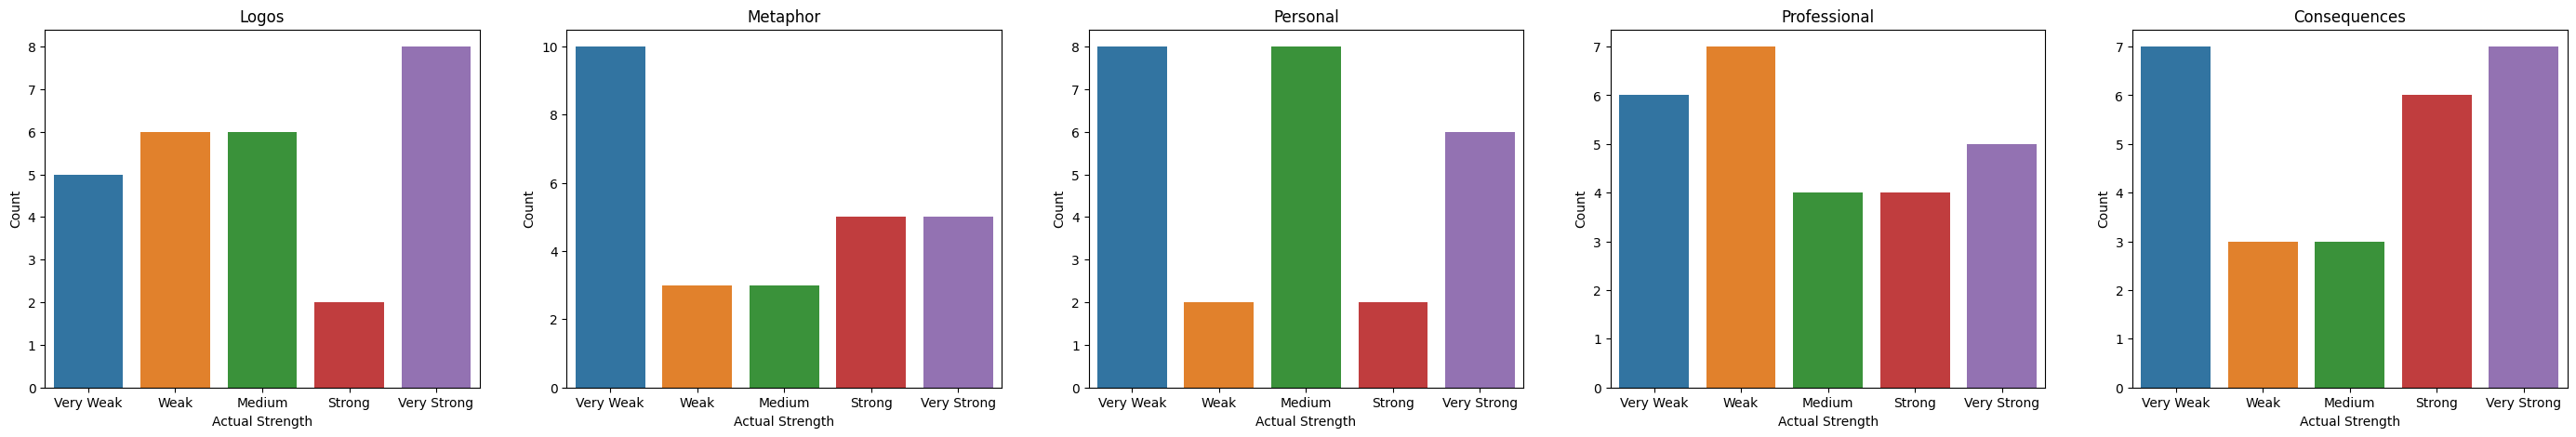

In [306]:
fig, axes = plt.subplots(1, 5,  figsize=(35, 5))
temp = password[['Actual Strength', 'design']]

def get_strength(x):
    return list(pass_stmap.keys())[list(pass_stmap.values()).index(float(x))]


for i, design in enumerate(did_map.values()):
    df = temp[temp['design']==design]['Actual Strength']
    strength_count = df.apply(lambda x: get_strength(x)).value_counts().rename_axis("Actual Strength").reset_index(name="Count")
    sns.barplot(data=strength_count, x='Actual Strength', y='Count', order=['Very Weak', 'Weak', 'Medium', 'Strong', 'Very Strong'], ax= axes[i])
    axes[i].set_title(design)